## Preprocessing ECG signals

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ptbxl.utils.paths import data_interim_dir, data_raw_dir
from ptbxl.data.make_dataset import load_raw_data
from ptbxl.data.signal_preprocessing import SignalPreprocessing

sns.set_theme()

preprocessing = SignalPreprocessing()

In [3]:
# Load data
dataset_metadata = pd.read_csv(data_interim_dir("dataset_metadata.csv"))
print(f"Number of records: {len(dataset_metadata)}")
display(dataset_metadata.head())

Number of records: 9553


,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,max_likelihood,target
0,17,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-20 14:25:25,...,", alles,",NaN,NaN,NaN,NaN,9,records100/00000/00017_lr,records500/00000/00017_hr,AFLT,1.0
1,18,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-20 15:17:24,...,", alles,",NaN,NaN,NaN,NaN,9,records100/00000/00018_lr,records500/00000/00018_hr,AFLT,1.0
2,20,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-23 12:55:32,...,NaN,NaN,NaN,VES,NaN,9,records100/00000/00020_lr,records500/00000/00020_hr,AFLT,1.0
3,23,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-25 12:49:40,...,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00023_lr,records500/00000/00023_hr,AFLT,1.0
4,34,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-02-10 12:04:03,...,", alles,",NaN,NaN,NaN,NaN,9,records100/00000/00034_lr,records500/00000/00034_hr,AFLT,1.0


## Load ECG signals

- $m$: is the number of patients
- $n$: is the length of the signal
- Lead: are the number of channels. In this case 12

In [4]:
# Leads names
leads = ['I', 'II', 'III', 'aVF', 'aVR', 'aVL', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

In [5]:
fs = 100 # Sampling rate (Hz)
ecgs = load_raw_data(
    dataset_metadata, 
    sampling_rate=fs, 
    path=data_raw_dir("physionet.org/files/ptb-xl/1.0.3"),
)

m, n, lead = ecgs_data_shape = ecgs.shape
dur = n/fs
t = np.arange(0, dur, 1/fs)

print(f"Signald block shape (m, n, lead): {ecgs_data_shape}")
print(f"Signals duration: {dur}")

Signald block shape (m, n, lead): (9553, 1000, 12)
Signals duration: 10.0


## Remove first and last second of the ECGs

In [6]:
ecgs = ecgs[:, 1*fs:-1*fs, :]
m, n, lead = ecgs_data_shape = ecgs.shape
dur = n/fs
t = np.arange(0, dur, 1/fs)

print(f"Signald block shape (m, n, lead): {ecgs_data_shape}")
print(f"Signals duration: {dur}")

Signald block shape (m, n, lead): (9553, 800, 12)
Signals duration: 8.0


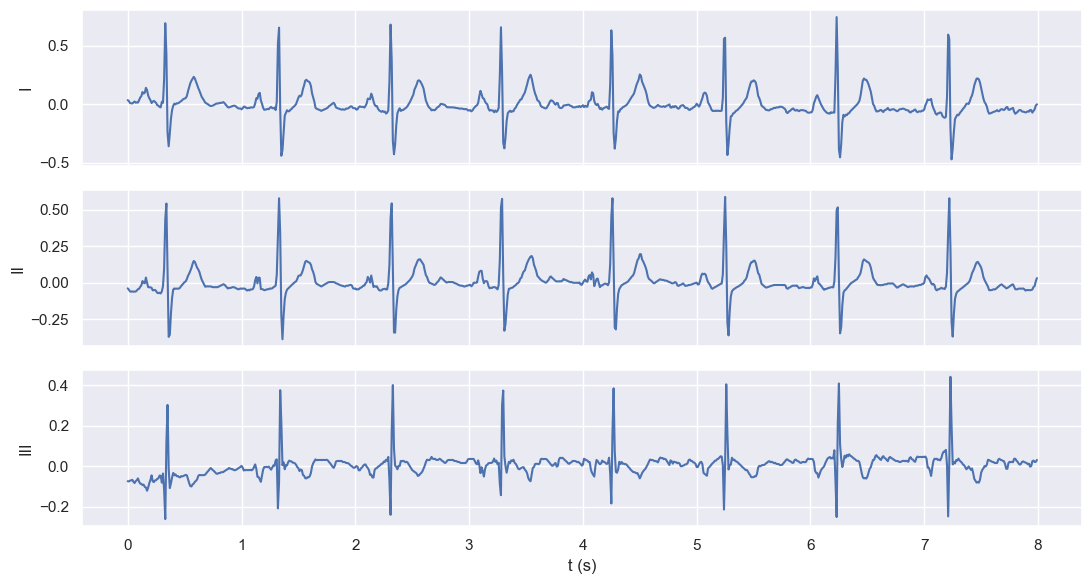

In [7]:
idx = np.random.randint(0, m) # Get ECG random index

fig, ax = plt.subplots(3, 1, figsize=(11, 6), sharex=True, sharey=False)
for i in range(3):
    ax[i].plot(t, ecgs[idx, :, i].ravel())
    ax[i].set_ylabel(leads[i])
ax[i].set_xlabel('t (s)')
plt.tight_layout()
plt.show()

## Mean removal

In [8]:
ecgs_m0 = preprocessing.mean_removal(ecgs)

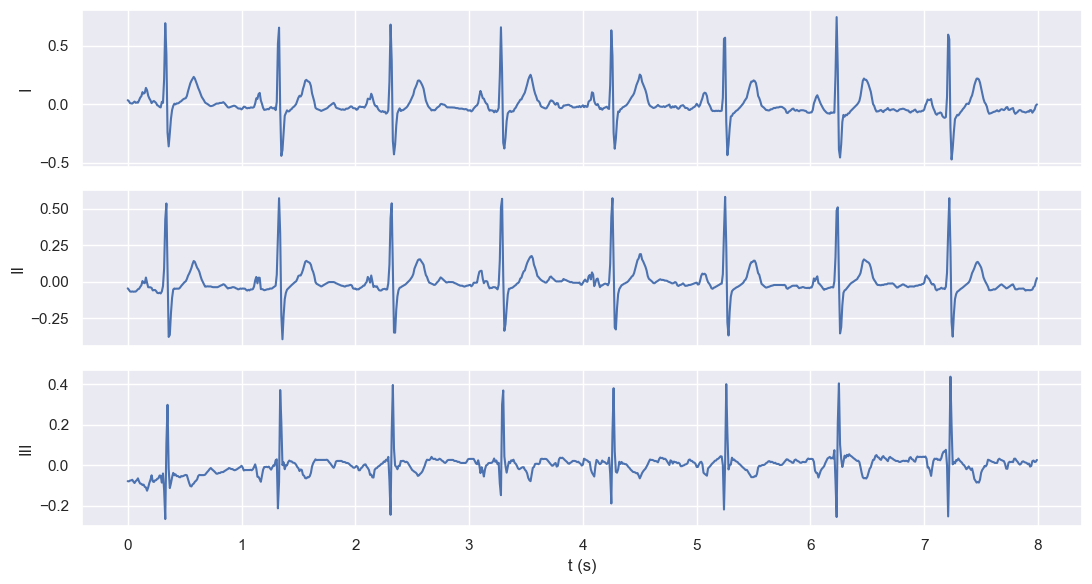

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(11, 6), sharex=True, sharey=False)
for i in range(3):
    ax[i].plot(t, ecgs_m0[idx, :, i].ravel())
    ax[i].set_ylabel(leads[i])
ax[i].set_xlabel('t (s)')
plt.tight_layout()
plt.show()

## Wander removal

In [10]:
ecgs_w0 = preprocessing.wander_removal(ecgs_m0, fs)

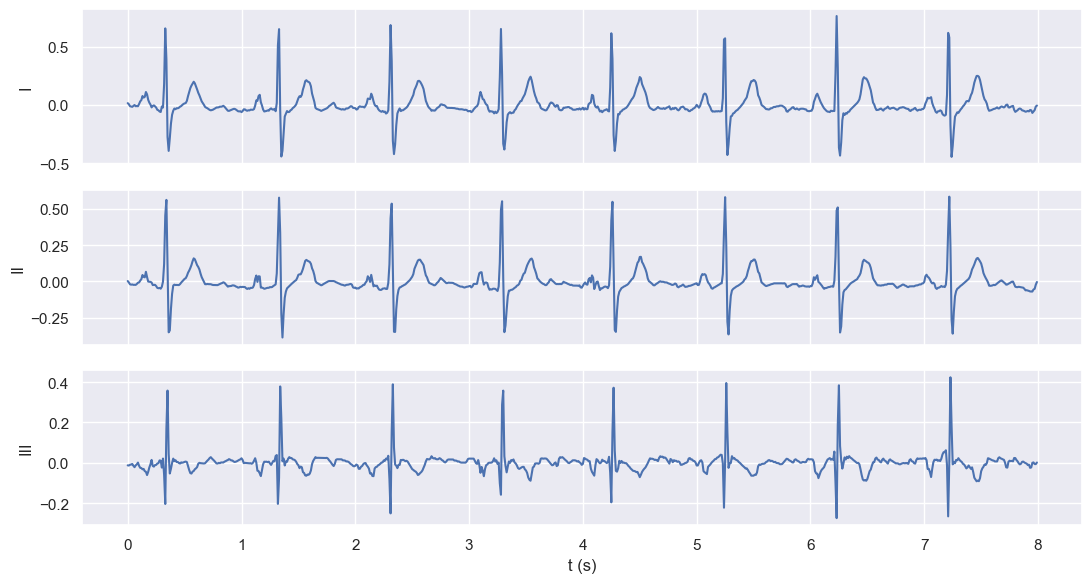

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(11, 6), sharex=True, sharey=False)
for i in range(3):
    ax[i].plot(t, ecgs_w0[idx, :, i].ravel())
    ax[i].set_ylabel(leads[i])
ax[i].set_xlabel('t (s)')
plt.tight_layout()
plt.show()

## Pan–Tompkins algorithm

In [12]:
w = int((150/1000)*fs)  # Moving average window size (150ms)
ecgs_pt = preprocessing.pan_tompkins(ecgs_w0, fs, w)

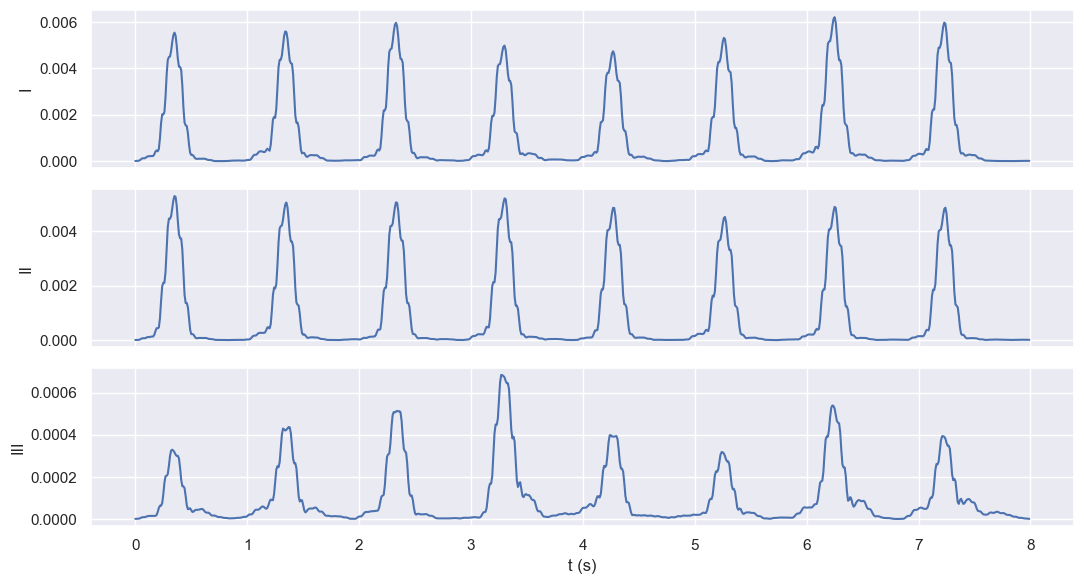

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(11, 6), sharex=True, sharey=False)
for i in range(3):
    ax[i].plot(t, ecgs_pt[idx, :, i].ravel())
    ax[i].set_ylabel(leads[i])
ax[i].set_xlabel('t (s)')
plt.tight_layout()
plt.show()